In [4]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn import svm, datasets
import matplotlib.pyplot as plt
import pandas as pd
df = pd.read_csv('BilStatistics.csv')
import seaborn as sns
from scipy import stats


# Problem Statement

    The problem statement for this dataset is to create a prediction model on the networth of individuals and  what variables can influence them the most and to build an acurate way to predict the ranking of the individuals. 

# DataSet

    This data set is a breakdown of an idividuals networth and the factors and variables about that person such as the category of buisness they work in, whether they are self made, the source of there income and many more

# Target variable

    My target varible will be finalWorth for this data set as it will be a good comparison for the factors that make a person wealthy and to see if there is any significant variable that makes someone rank higher in the wealth score
    

# Prediction goal 
    My prediction goal is to accurately predict if there is a correlation to to the  the final net worth and various other financial, economic, and demographic variables in the dataset.

In [5]:
#Dropping unwanted features
unwanted_features = ['personName', 'source', 'organization', 'lastName','latitude_country', 'longitude_country','birthDate']
df = df.drop(unwanted_features, axis=1)

In [6]:

#Missing values
missing_values = df.isnull().sum()
print(missing_values)


rank                                             0
finalWorth                                       0
category                                         0
age                                             65
country                                         38
city                                            72
industries                                       0
countryOfCitizenship                             0
selfMade                                         0
status                                           0
gender                                           0
firstName                                        3
title                                         2301
date                                             0
state                                         1887
residenceStateRegion                          1893
birthYear                                       76
birthMonth                                      76
birthDay                                        76
cpi_country                    

In [7]:
df = df.dropna()

In [8]:
#Droping the duplicates
df = df.drop_duplicates()

In [9]:
print(df)

      rank  finalWorth               category   age        country  \
1        2      180000             Automotive  51.0  United States   
2        3      114000             Technology  59.0  United States   
3        4      107000             Technology  78.0  United States   
4        5      106000  Finance & Investments  92.0  United States   
5        6      104000             Technology  67.0  United States   
...    ...         ...                    ...   ...            ...   
2519  2405        1100                 Sports  47.0  United States   
2566  2540        1000       Fashion & Retail  66.0  United States   
2581  2540        1000                 Sports  38.0  United States   
2602  2540        1000             Technology  36.0  United States   
2608  2540        1000  Media & Entertainment  53.0  United States   

                city             industries countryOfCitizenship  selfMade  \
1             Austin             Automotive        United States      True   
2  

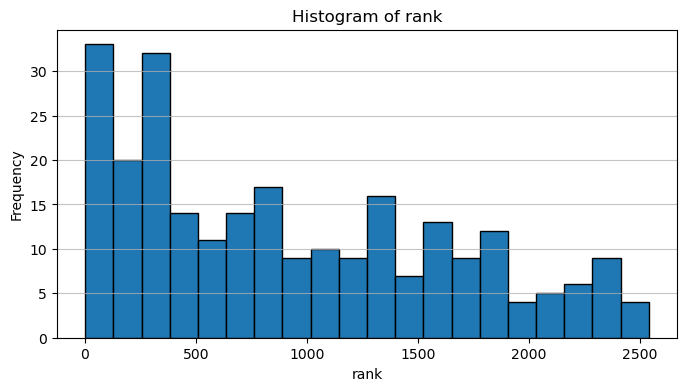

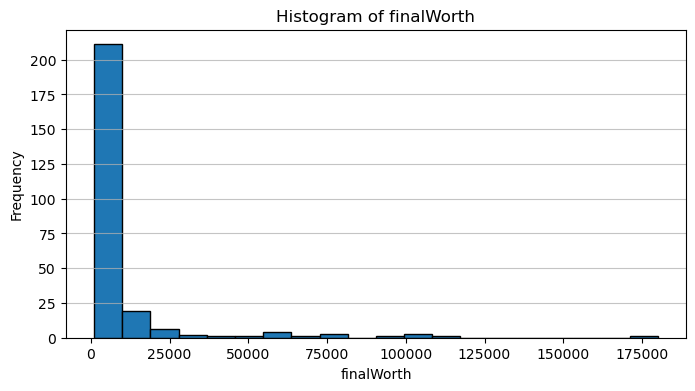

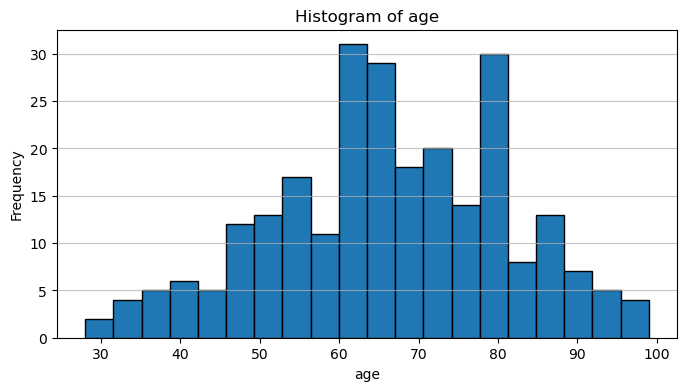

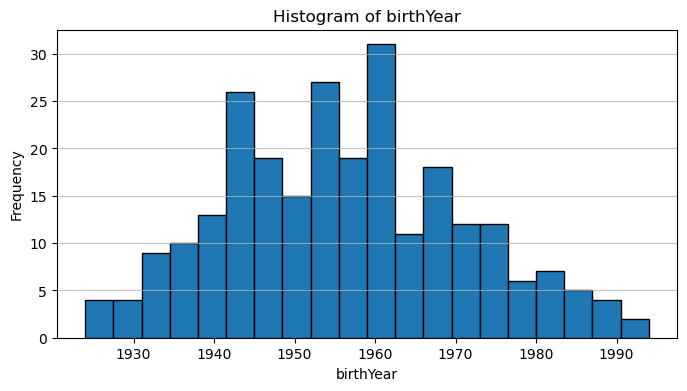

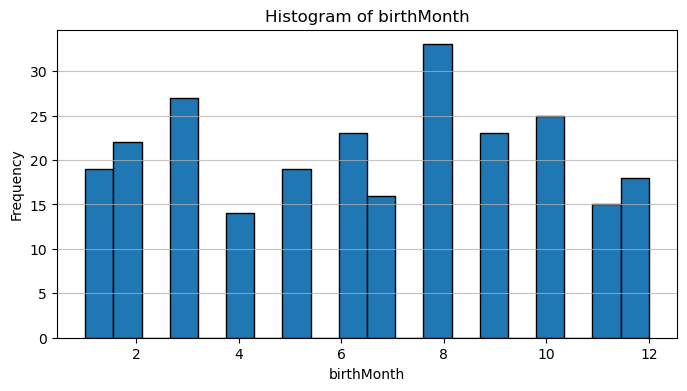

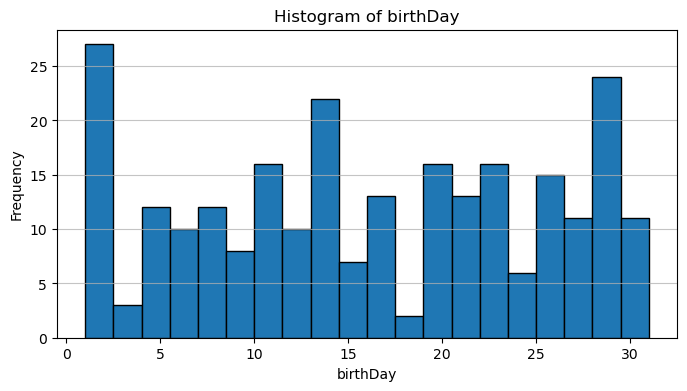

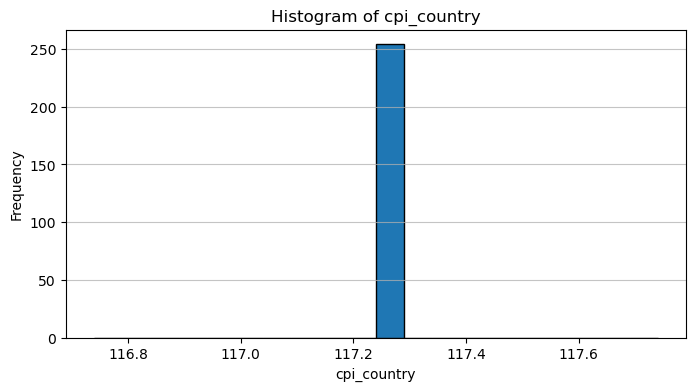

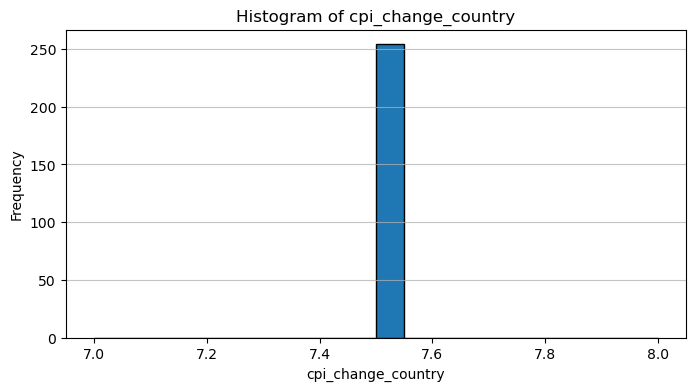

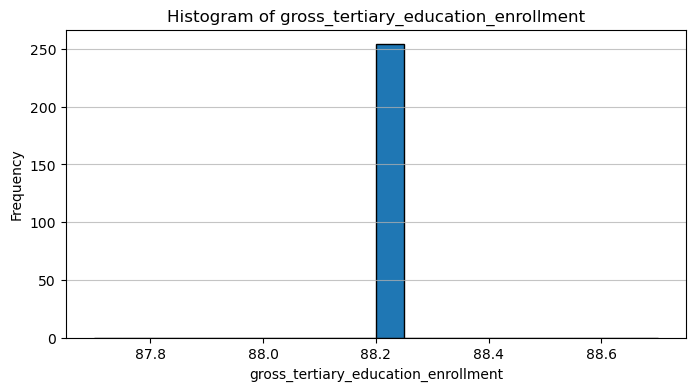

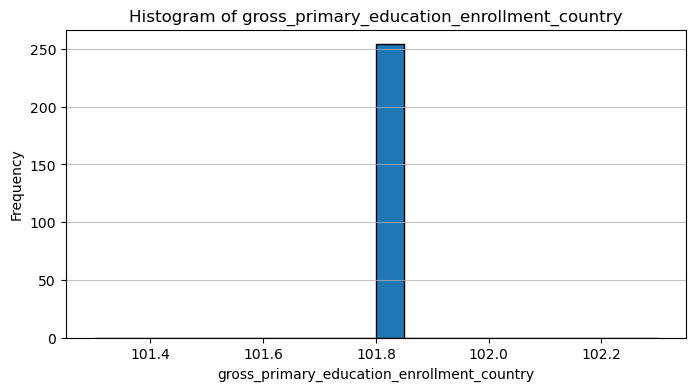

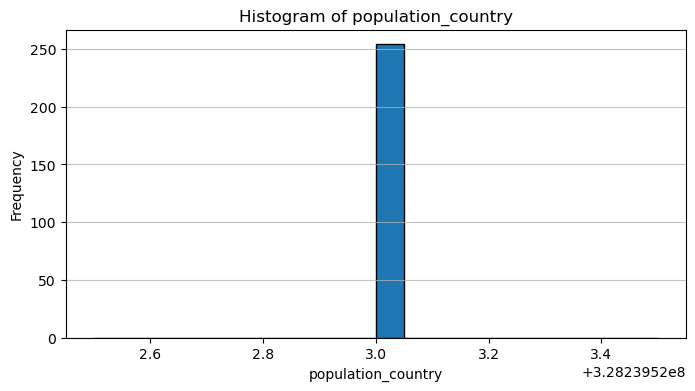

In [24]:
#Histogram when looking for outliers 
numeric_columns = df.select_dtypes(include=['int64', 'float64'])

num_bins = 20

# Create histograms for each numerical column
for column in numerical_columns.columns:
    plt.figure(figsize=(8, 4))
    plt.hist(numerical_columns[column], bins=num_bins, edgecolor='k')
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

In [11]:
#Dropping the outliers
Q1 = numeric_columns.quantile(0.25)
Q3 = numeric_columns.quantile(0.75)
IQR = Q3 - Q1

outlier_threshold = 1.5

outlier = ((numeric_columns < (Q1 - outlier_threshold * IQR)) | (numeric_columns > (Q3 + outlier_threshold * IQR))).any(axis=1)
cleaned_df = df[~outlier]


print("Original DataFrame shape:", df.shape)
print("Cleaned DataFrame shape:", cleaned_df.shape)


Original DataFrame shape: (254, 28)
Cleaned DataFrame shape: (223, 28)


In [12]:
#chi- squared test
from sklearn.feature_selection import SelectKBest, chi2

x = df[['age', 'rank', 'total_tax_rate_country','tax_revenue_country_country','life_expectancy_country' ]]  
y = df['finalWorth'] 

fs = SelectKBest(score_func=chi2, k='all')  

bestFeatures = fs.fit(x, y)

feature_scores = bestFeatures.scores_
p_values = bestFeatures.pvalues_

np.set_printoptions(suppress=True)
print("Feature Scores:", feature_scores)
print("P-Values:", p_values)

Feature Scores: [   361.38254402 144832.53330591      0.              0.
      0.        ]
P-Values: [0. 0. 1. 1. 1.]


In [13]:
#Anova test for gender
import scipy.stats as stats

groups = df['gender'].unique()
anova_results = {}

for group in groups:
    group_data = df[df['gender'] == group]['finalWorth']
    anova_results[group] = group_data

f_statistic, p_value = stats.f_oneway(*anova_results.values())

print("F-statistic:", f_statistic)
print("P-value:", p_value)

F-statistic: 0.4130120546666647
P-value: 0.521028921686177


In [14]:
#Anova test for selfMade
selfmade_true = df[df['selfMade'] == True]['finalWorth']
selfmade_false = df[df['selfMade'] == False]['finalWorth']


f_statistic, p_value = stats.f_oneway(selfmade_true, selfmade_false)


print("\nANOVA for Self-Made")
print("F-statistic:", f_statistic)
print("P-value:", p_value)


ANOVA for Self-Made
F-statistic: 0.09544853634200323
P-value: 0.7576167578604768


in the chi2 test i found that the significant features are age and rank with the low significant features being total_tax_rate_country
, tax_revenue_country_country ,and life_expectancy_country

and from the anova test i found that neither selfMade or Gender have a significant influence.

There is also no high corelation in the variables as seen below

In [15]:
df.drop(columns=['total_tax_rate_country', 'tax_revenue_country_country', 'life_expectancy_country', 'gender','selfMade'], inplace=True)

In [16]:
#Correlation
numerical_columns = df.select_dtypes(include=[np.number])
correlation_matrix = numerical_columns.corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))


threshold = 0.7  


correlated = np.where((correlation_matrix > threshold) & (correlation_matrix < 1) & mask)


columns_to_drop = set()


for i, j in zip(*correlated):
    if i != j:
        feature_i = numerical_columns.columns[i]
        feature_j = numerical_columns.columns[j]
        columns_to_drop.add(feature_i)


columns_to_drop = list(columns_to_drop)


In [17]:
print(columns_to_drop)

[]


In [18]:
#Scaling up the features rank and age
from sklearn.preprocessing import MinMaxScaler

numerical_features = ['rank', 'age']

nor_x = MinMaxScaler()
x_scaled = nor_x.fit_transform(df[numerical_features])

In [19]:
print(df)

      rank  finalWorth               category   age        country  \
1        2      180000             Automotive  51.0  United States   
2        3      114000             Technology  59.0  United States   
3        4      107000             Technology  78.0  United States   
4        5      106000  Finance & Investments  92.0  United States   
5        6      104000             Technology  67.0  United States   
...    ...         ...                    ...   ...            ...   
2519  2405        1100                 Sports  47.0  United States   
2566  2540        1000       Fashion & Retail  66.0  United States   
2581  2540        1000                 Sports  38.0  United States   
2602  2540        1000             Technology  36.0  United States   
2608  2540        1000  Media & Entertainment  53.0  United States   

                city             industries countryOfCitizenship status  \
1             Austin             Automotive        United States      D   
2        

In [20]:
df = pd.get_dummies(df, columns=["category", "country", "city", "industries", "countryOfCitizenship", "status"])

In [21]:
#r2 test
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


numerical_features = df[['age', 'rank',]]

target = df['finalWorth']

X_train, X_test, y_train, y_test = train_test_split(numerical_features, target, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)


print(f"Mean Squared Error: {mse:.2f}")


Mean Squared Error: 179701857.77


In [22]:
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse:.2f}")

Root Mean Squared Error: 13405.29


In [23]:

r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2:.2f}")

R-squared: 0.39


The algorithum that I used is linear Regression and the metric is R-Squared. I also used the train test split instead of the the 
cross validation.

In [143]:
print(df)

      rank  finalWorth   age firstName                 title           date  \
1        2    180000.0  51.0      Elon                   CEO  4/4/2023 5:01   
2        3    114000.0  59.0      Jeff  Chairman and Founder  4/4/2023 5:01   
3        4    107000.0  78.0     Larry       CTO and Founder  4/4/2023 5:01   
4        5    106000.0  92.0    Warren                   CEO  4/4/2023 5:01   
5        6    104000.0  67.0      Bill               Cochair  4/4/2023 5:01   
...    ...         ...   ...       ...                   ...            ...   
2519  2405      1100.0  47.0     Tiger               Athlete  4/4/2023 5:01   
2566  2540      1000.0  66.0   William              Director  4/4/2023 5:01   
2581  2540      1000.0  38.0    LeBron               Athlete  4/4/2023 5:01   
2602  2540      1000.0  36.0   Apoorva               Founder  4/4/2023 5:01   
2608  2540      1000.0  53.0     Tyler              Director  4/4/2023 5:01   

           state residenceStateRegion  birthYear  b